# Appendix A: 

ADS 599 Capstone: NLP + Machine Learning Techniques to Identifying Fake Job Postings

Team 2:
* Brianne Bell 
* Zachariah Freitas

## Data Importing and Pre-processing
* Step 1: Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Step 2: Clean, wrangle, and handle missing and duplicated data
* Step 3: Transform data appropriately using nlp techniques such as feature embedding construction

### Dataset Description
This dataset contains approximately 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. We will use this dataset to create classification models to determine which job descriptions are fraudulent.

Origin: Kaggle \
File Type: CSV \
File Size: 47.7 MB \
Modeling Problem: Classification \
Missing Values: Yes \
Duplicated Values: Yes \
Unbalanced Dataset: Yes 

## Data Analysis and Visualization
* Identify categorical, ordinal, and numerical variables within data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest
## Feature Descriptions
### Categorical Features:
* title: The title of the job ad entry. (text)
* location: Geographical location of the job ad. (categorical: e.g. US, NY, New York)
* department: Corporate department (categorical: e.g. sales).
* salary_range: Indicative salary range (categorical: e.g. $50,000-$60,000)
* company_profile: A brief company description. (text)
* description: The details description of the job ad. (text)
* requirements: Enlisted requirements for the job opening. (text)
* benefits: Enlisted offered benefits by the employer. (text)
* employment_type: Full-type, Part-time, Contract, etc. (categorical: e.g. Full-type)
* required_experience: Executive, Entry level, Intern, etc. (categorical: e.g. Executive)
* required_education: Doctorate, Master’s Degree, Bachelor, etc. (categorical: e.g. Bachelor)
* industry: Automotive, IT, Health care, Real estate, etc. (categorical: e.g. Automotive)
* function: Consulting, Engineering, Research, Sales etc. (categorical: e.g. Engineering)

### Numerical Features:
* job_id: Unique Job ID (numeric)
* telecommuting: True for telecommuting positions. (Binary: 1="True",0="False")
* has_company_logo: True if company logo is present. (Binary: 1="True",0="False") 
* has_questions: True if screening questions are present. (Binary: 1="True",0="False") 

### Target Feature:
* fraudulent: Target - Classification attribute. Is the job posting fraudulent? (Binary: 1="True",0="False") 

In [33]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import os
import re
import random
import time
import datetime
import missingno
from scipy.stats import chi2_contingency

import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec # to do the grid of plots

%matplotlib inline

# Read Dataset and Display Info
Loading up the original data from Kaggle.

In [97]:
file_path = '../Data Folder/fake_job_postings.csv'
raw_df = pd.read_csv(file_path)
print('Raw Data Shape: ')
print(raw_df.shape)
print('\nColumns in the raw data:')
print(raw_df.columns)
print('\n\n',raw_df.info())

Raw Data Shape: 
(17880, 18)

Columns in the raw data:
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   bene

# Display Columns

In [98]:
# example of data contents
raw_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


There are 18 columns, one of which is the outcome called fraudulent.
There are 17,880 entries, but there are null entries throughout. 

# Duplicates
Reviewing data for duplicated rows.

In [4]:
# Count the number of dubplicated rows.
n = len(raw_df)-len(raw_df.drop_duplicates())

print("No. of duplicated rows :", n)

No. of duplicated rows : 0


In [5]:
# check the cardinality for each column
n = raw_df.nunique(axis=0)
  
print(f"No. of unique values in each column :\n{n}")

No. of unique values in each column :
job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64


There are no duplicated rows in the data.

job_id appears to have no value in this analysis and is an id associated with the posting, not controled by the poster.

In [6]:
# Let's check the number of duplicated rows in the dataset after removing the job_id column.
n = len(raw_df.loc[:, raw_df.columns!='job_id'])-len(raw_df.loc[:, raw_df.columns!='job_id'].drop_duplicates())

print("No. of duplicated rows :", n)

No. of duplicated rows : 281


# Deduplicating Data

In [7]:
dd_raw_df = raw_df.loc[:, raw_df.columns!='job_id'].drop_duplicates()

print("Undeduplicated Data Shape: ")
print(raw_df.fraudulent.value_counts())

print("\nDeduplicated Data Shape: ")
print(dd_raw_df.fraudulent.value_counts())

Undeduplicated Data Shape: 
0    17014
1      866
Name: fraudulent, dtype: int64

Deduplicated Data Shape: 
0    16743
1      856
Name: fraudulent, dtype: int64


Most of the duplicated rows are in the non-fraudulent group. 
I think we can safely drop duplicated rows and job_id from our dataset.

# Missing Data

In [8]:
# looking at what is null
print(dd_raw_df.isnull().sum().sort_values(ascending=False))
print('\nTotal number of null values: ', dd_raw_df.isnull().sum().sum())


salary_range           14772
department             11328
required_education      8009
benefits                7106
required_experience     6962
function                6363
industry                4837
employment_type         3428
company_profile         3282
requirements            2648
location                 341
description                1
title                      0
telecommuting              0
has_questions              0
has_company_logo           0
fraudulent                 0
dtype: int64

Total number of null values:  69077


<AxesSubplot: >

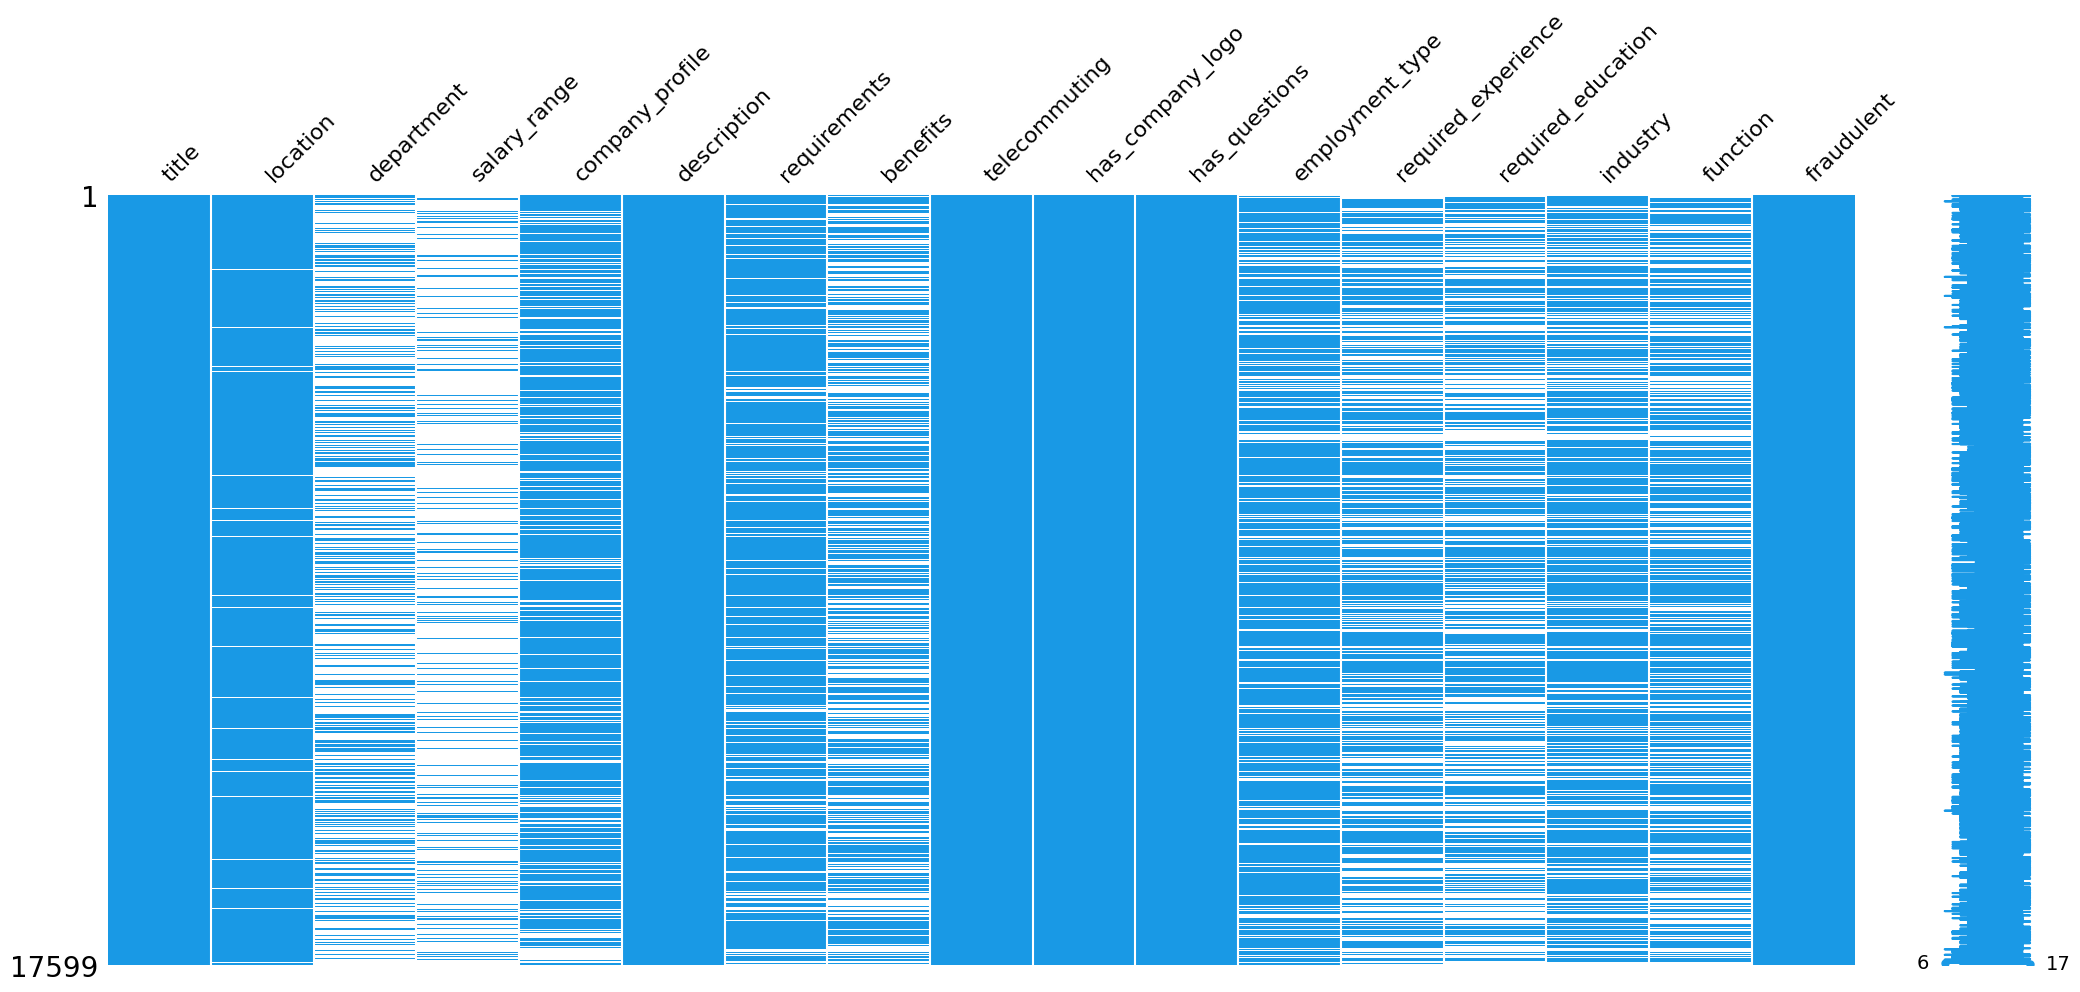

In [9]:
# checking missing data in our dataframe.
missingno.matrix(dd_raw_df,color=(0.1, 0.6, 0.9))

Columns with no missing data:
* job_id
* title
* telecommuting
* has_company_logo
* has_questions
* fraudulent

The description field is only missing one entry.

job_id appears to have no value and is an id associated with the posting, not controled by the poster.

The largest amount of missing entries is in salary_range followed by department. 

We note a total of 70,103 null values occuring across all features.

In [10]:
# looking at what is null when fraudulent is 1
print(dd_raw_df[dd_raw_df['fraudulent']==1].shape)
print(dd_raw_df[dd_raw_df['fraudulent']==1].isnull().sum().sort_values(ascending=False))
print('\nTotal number of null values: ', dd_raw_df[dd_raw_df['fraudulent']==1].isnull().sum().sum())

(856, 17)
salary_range           635
company_profile        580
department             524
required_education     444
required_experience    427
benefits               359
function               330
industry               270
employment_type        236
requirements           151
location                19
description              1
title                    0
telecommuting            0
has_questions            0
has_company_logo         0
fraudulent               0
dtype: int64

Total number of null values:  3976


<AxesSubplot: >

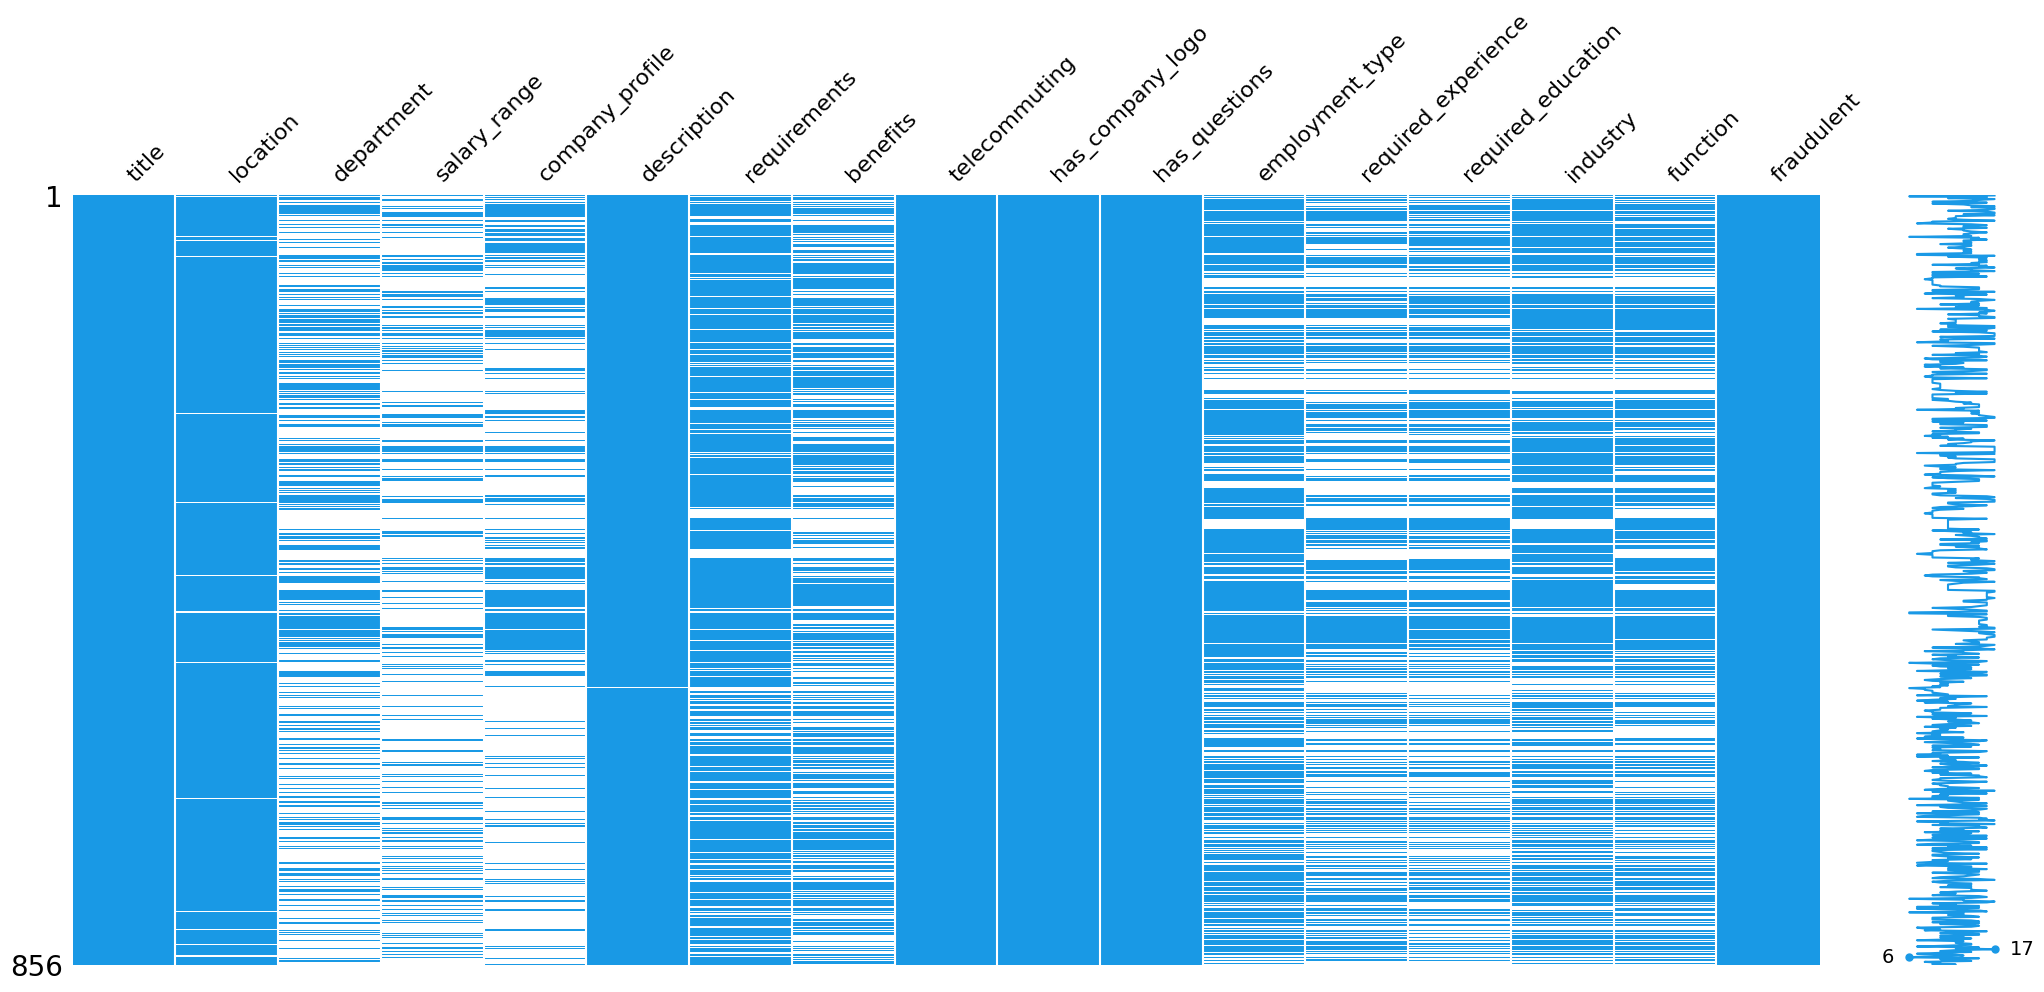

In [11]:
# checking missing data in our dataframe when fraudulent is 1
missingno.matrix(dd_raw_df[dd_raw_df['fraudulent']==1],color=(0.1, 0.6, 0.9))

# Categorical EDA

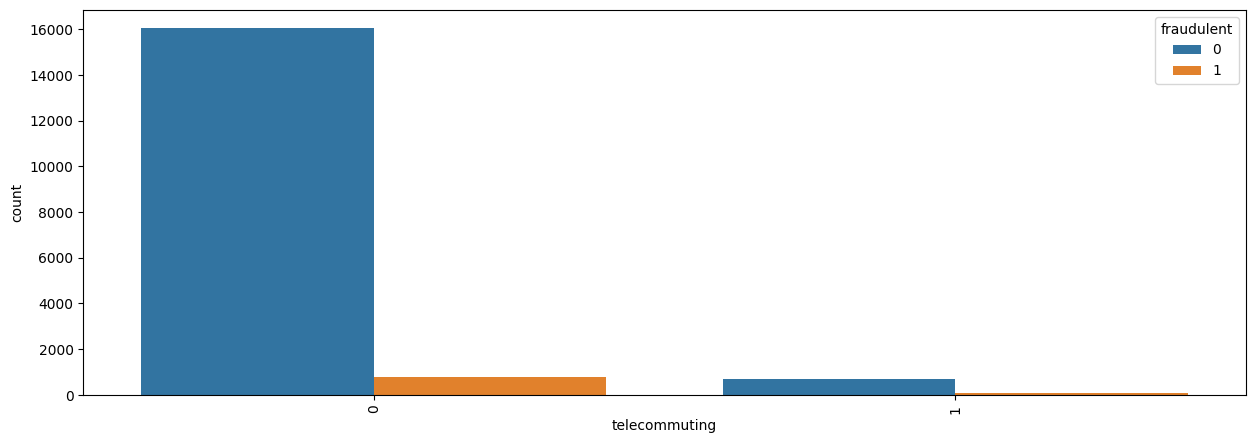

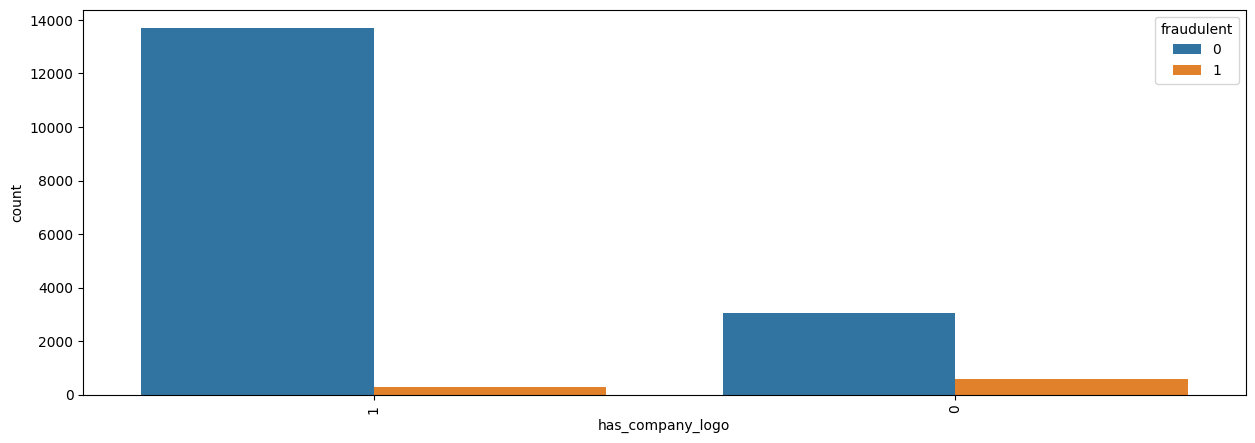

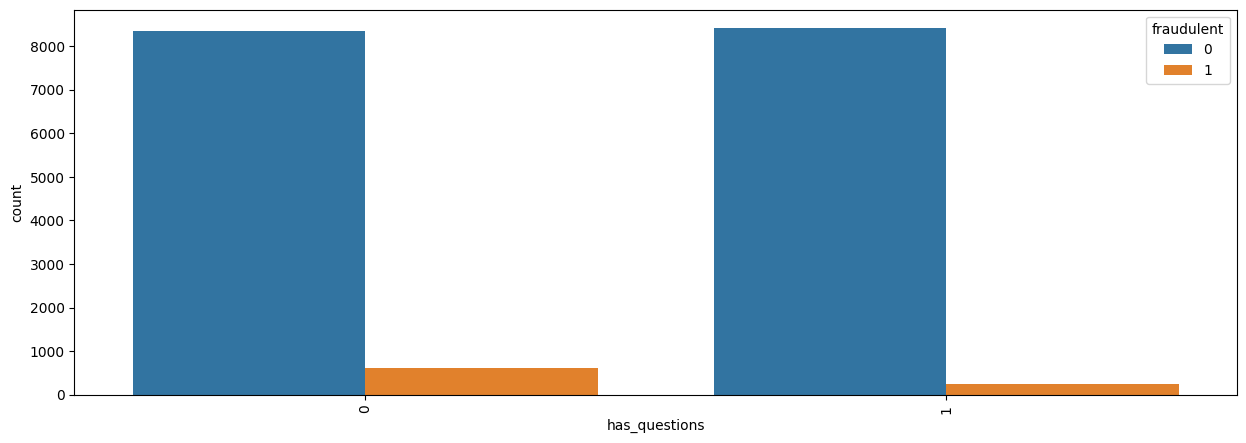

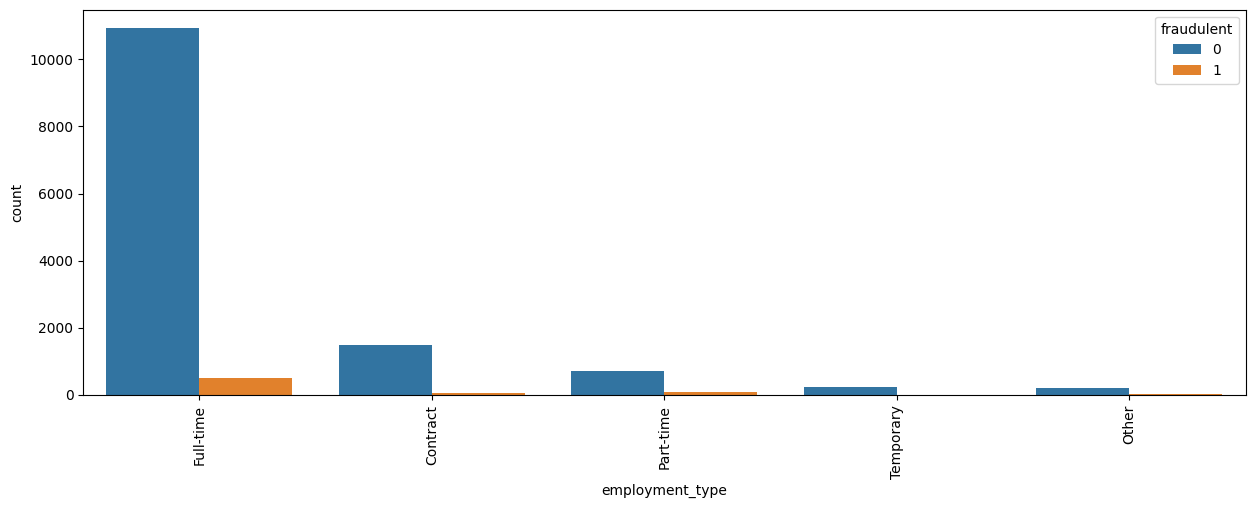

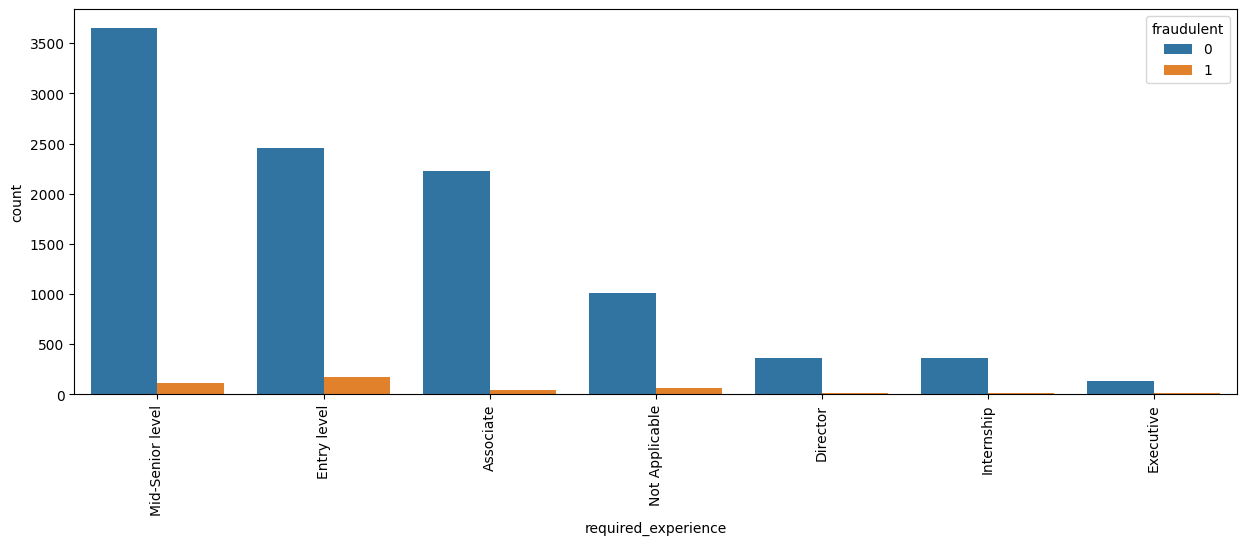

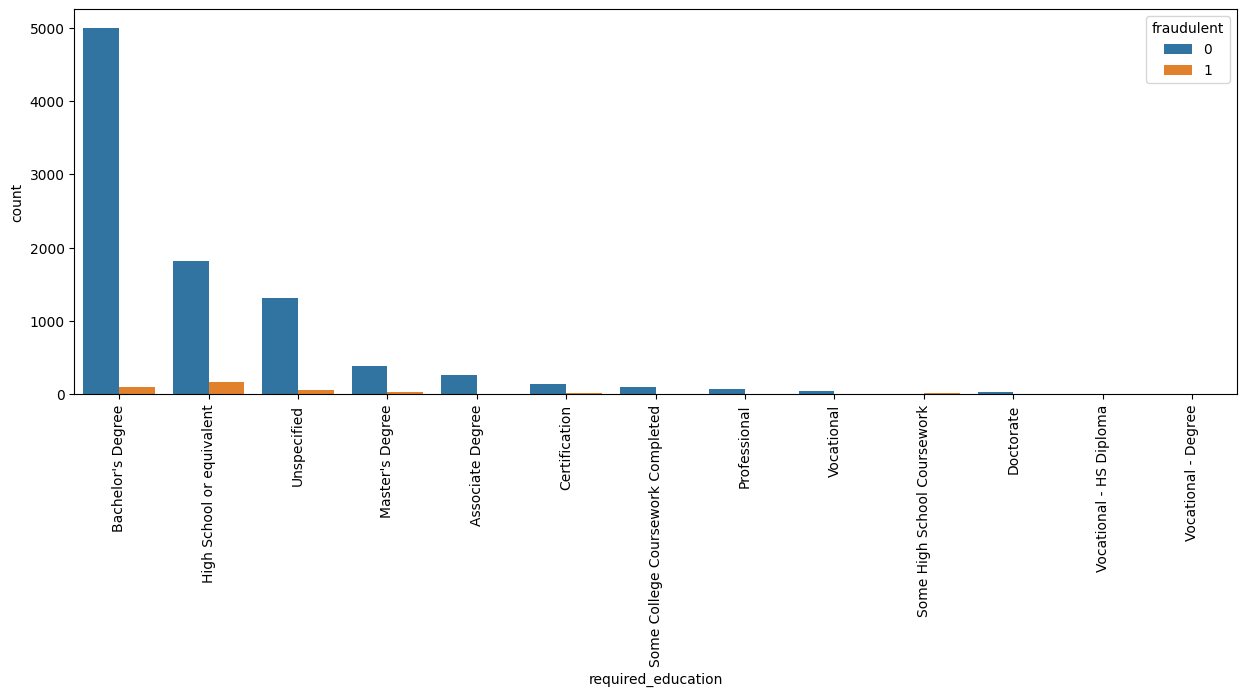

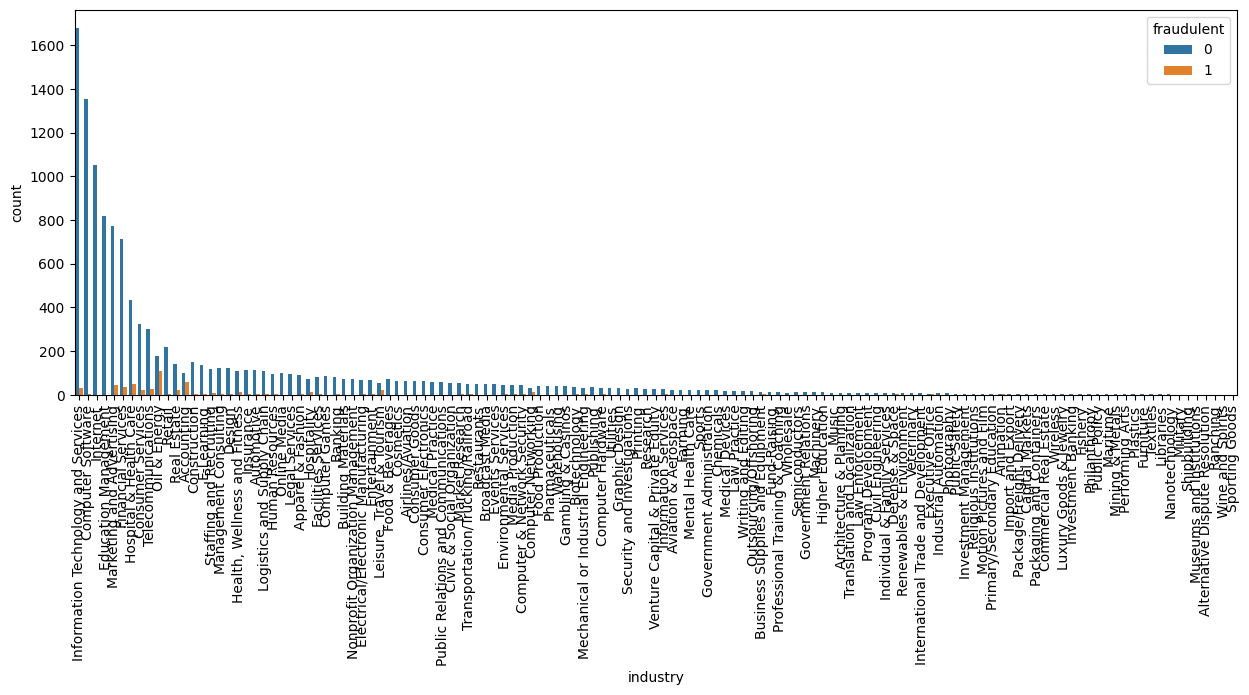

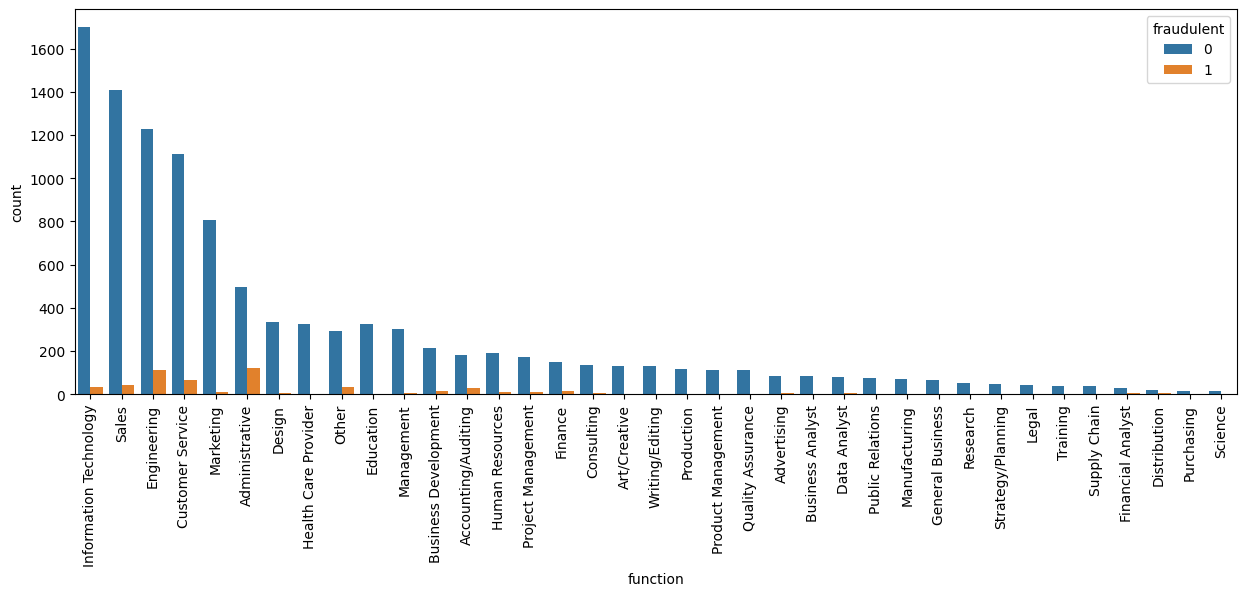

In [101]:
# Plot the categorical variables with low cardinality vs target variable.
cat_vars = ["telecommuting", "has_company_logo", "has_questions", 
            "employment_type", "required_experience", "required_education",
            "industry", "function"]

for col in cat_vars:
    plt.figure(figsize=(15,5))
    ax = sns.countplot(data = dd_raw_df, x = col, hue = 'fraudulent', 
                       order = dd_raw_df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.show()

We observe for many of our categorical variables that fake posting rates are largely proportional to each other with visible exceptions notable in telecommuting, has_company_logo, has_questions, function, and industry. We calculate the deposit rates for each category.

In [104]:
print(dd_raw_df.fraudulent.value_counts(normalize = True))
print('\n')
for col in cat_vars:
    print('{} split'.format(col))
    print('\n')
    p1 = dd_raw_df[(dd_raw_df.fraudulent == 1)].groupby(col).size().reset_index(name='fraud_counts')
    p2 = dd_raw_df.groupby(col).size().reset_index(name='total_counts')
    p1['total_count'] = p2['total_counts']
    p1['percent_yes'] = p1['fraud_counts']/p2['total_counts']
    print(p1)
    print('\n')

0    0.951361
1    0.048639
Name: fraudulent, dtype: float64


telecommuting split


   telecommuting  fraud_counts  total_count  percent_yes
0              0           792        16845     0.047017
1              1            64          754     0.084881


has_company_logo split


   has_company_logo  fraud_counts  total_count  percent_yes
0                 0           574         3623     0.158432
1                 1           282        13976     0.020177


has_questions split


   has_questions  fraud_counts  total_count  percent_yes
0              0           607         8940     0.067897
1              1           249         8659     0.028756


employment_type split


  employment_type  fraud_counts  total_count  percent_yes
0        Contract            43         1514     0.028402
1       Full-time           487        11423     0.042633
2           Other            15          225     0.066667
3       Part-time            73          772     0.094560
4       Temporary         

From these statistics we observe that:

* Postings with telecommuting are about twice as likely to be fraudulent than those without telecommuting.
* Postings without a company logo are about 7 times as likely to be fraudulent than those with a logo.
* Posting where screening questions are not present are 3 times more likely to be fraudulent than those with.
* Part-time and Other employment types tend to have a higher likelihood of being fraudulent than other categories.


# Bivariate EDA
## Correlation Analysis

In [51]:
# Pearson Correlation Table
    """ 
    Pearson r correlation is the most widely used correlation statistic 
    to measure the degree of the relationship between linearly related variables. 
    """ 
cm = sns.light_palette("green", as_cmap=True)
dd_raw_df.corr(method='pearson').style.background_gradient(cmap=cm)

C:\Users\zfreitas\AppData\Local\Temp\ipykernel_19584\2919783051.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dd_raw_df.corr(method='pearson').style.background_gradient(cmap=cm)


,telecommuting,has_company_logo,has_questions,fraudulent
telecommuting,1.000000,-0.021359,0.019094,0.035644
has_company_logo,-0.021359,1.000000,0.233755,-0.259868
has_questions,0.019094,0.233755,1.000000,-0.090966
fraudulent,0.035644,-0.259868,-0.090966,1.000000


# Pairplots

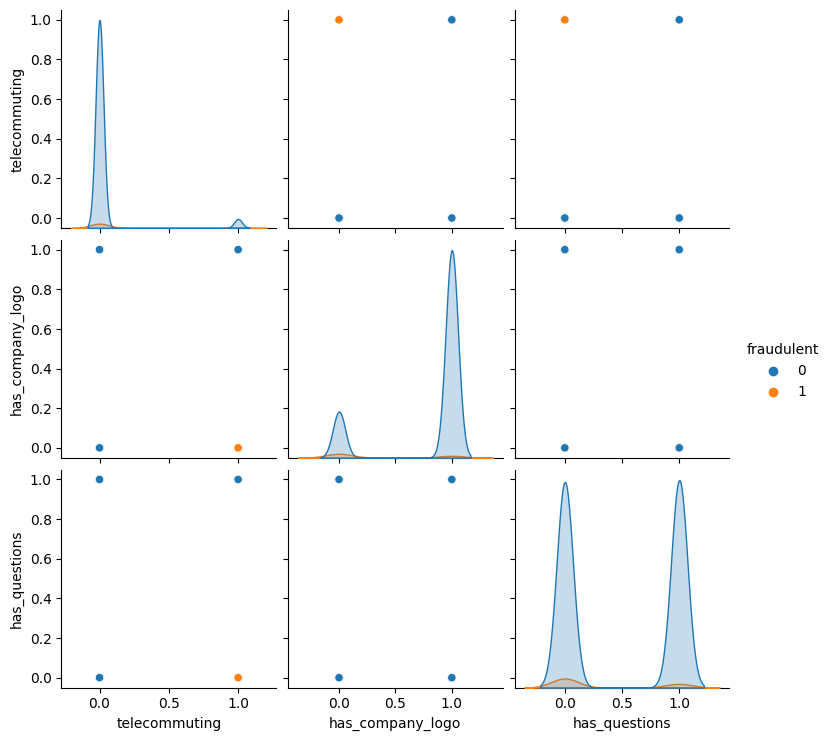

In [13]:
# Pairplot of the data
sns.pairplot(dd_raw_df, hue = 'fraudulent')

# Look at Target Feature Balance

In [85]:
# Helper Functions

# Bar Plot
def target_distribution(data, target):
    '''
        This fuction displays the distribution of the specified numeric variable in the input data frame.
        
        params:
        data: input data frame.
        target: string specifying the name of target variable.
        
        Returns: None.
        
    '''
    data = data.copy()
    sns.countplot(data=data,x=target,palette=['black','gray']);
    tgt_cnt = data[target].value_counts()
    tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)
    plt.text(x=-0.2,y=tgt_cnt[0]/2,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)',backgroundcolor='white')
    plt.text(x=0.8,y=tgt_cnt[1]/2,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)',backgroundcolor='white')
    plt.title('Target Distribution')
    
    
def categorical_variables_vs_target(data, categorical_variables, target):
    categorical_variables = categorical_variables.copy()
    data = data.copy()
    categorical_variables = categorical_variables.copy()
    for i in categorical_variables:
        ct = pd.crosstab(columns=data[i],index=data[target])
        stat, p, dof, expected = chi2_contingency(ct) 
        print(f"\n{'-'*len(f'Chi-Square test between {i} & {target}')}")
        print(f'Chi-Square test between {i} & {target}')
        print(f"{'-'*len(f'Chi-Square test between {i} & {target}')}")
        print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}")
        print(f"\nP-VALUE: {p}")
        print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")

In [87]:
categorical_variables = list(dd_raw_df.select_dtypes('object').columns)

numeric_variables = list(dd_raw_df.select_dtypes(['float64','int64']).columns)
numeric_variables.remove('fraudulent')

target = 'fraudulent'

print(f'Categorical Variables ({len(categorical_variables)}):\n{categorical_variables}' + 
      f'\n\nNumeric Variables ({len(numeric_variables)}):\n{numeric_variables}' + 
      f'\n\nTarget:\n{target}')

Categorical Variables (8):
['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits']

Numeric Variables (3):
['telecommuting', 'has_company_logo', 'has_questions']

Target:
fraudulent


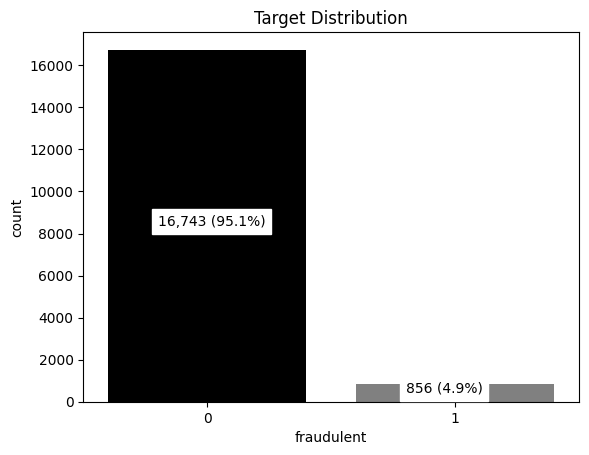

In [89]:
# Plot Target Variable fraudulent distribution.
target_distribution(data=dd_raw_df,
                       target=target)

In [54]:
dd_raw_df.groupby('fraudulent').mean()

C:\Users\zfreitas\AppData\Local\Temp\ipykernel_19584\47913107.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dd_raw_df.groupby('fraudulent').mean()


,telecommuting,has_company_logo,has_questions
fraudulent,,,
0,0.041211,0.817894,0.502299
1,0.074766,0.329439,0.290888


In [90]:
# Look for significant relationship between categorical variables and target variable.
categorical_variables_vs_target(data=dd_raw_df,
                                categorical_variables=categorical_variables,
                                target=target)


------------------------------------------
Chi-Square test between title & fraudulent
------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & TITLE
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & TITLE

P-VALUE: 3.5022563223378587e-165
REJECT H0

---------------------------------------------
Chi-Square test between location & fraudulent
---------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & LOCATION
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & LOCATION

P-VALUE: 0.0
REJECT H0

-----------------------------------------------
Chi-Square test between department & fraudulent
-----------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & DEPARTMENT
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & DEPARTMENT

P-VALUE: 6.770599457599411e-220
REJECT H0

-------------------------------------------------
Chi-Square test between salary_range & fraudulent
----------------------------

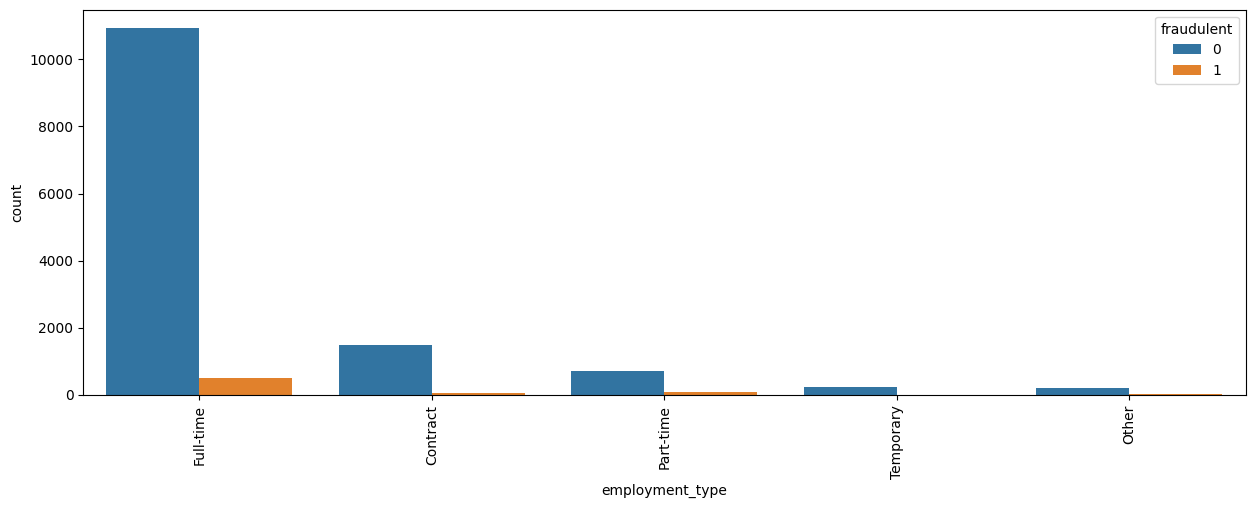

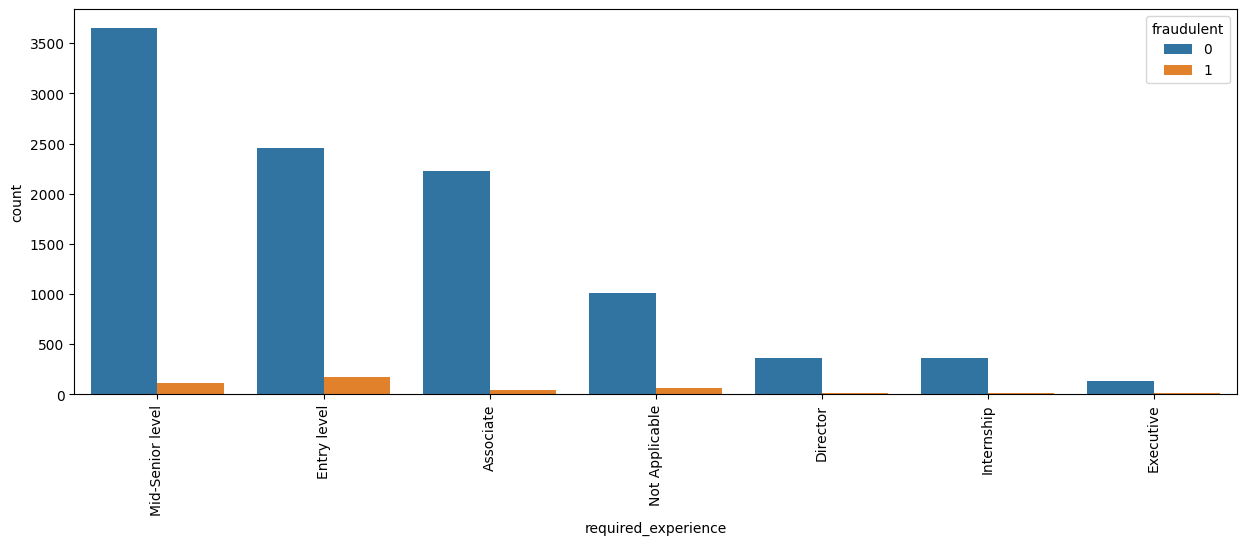

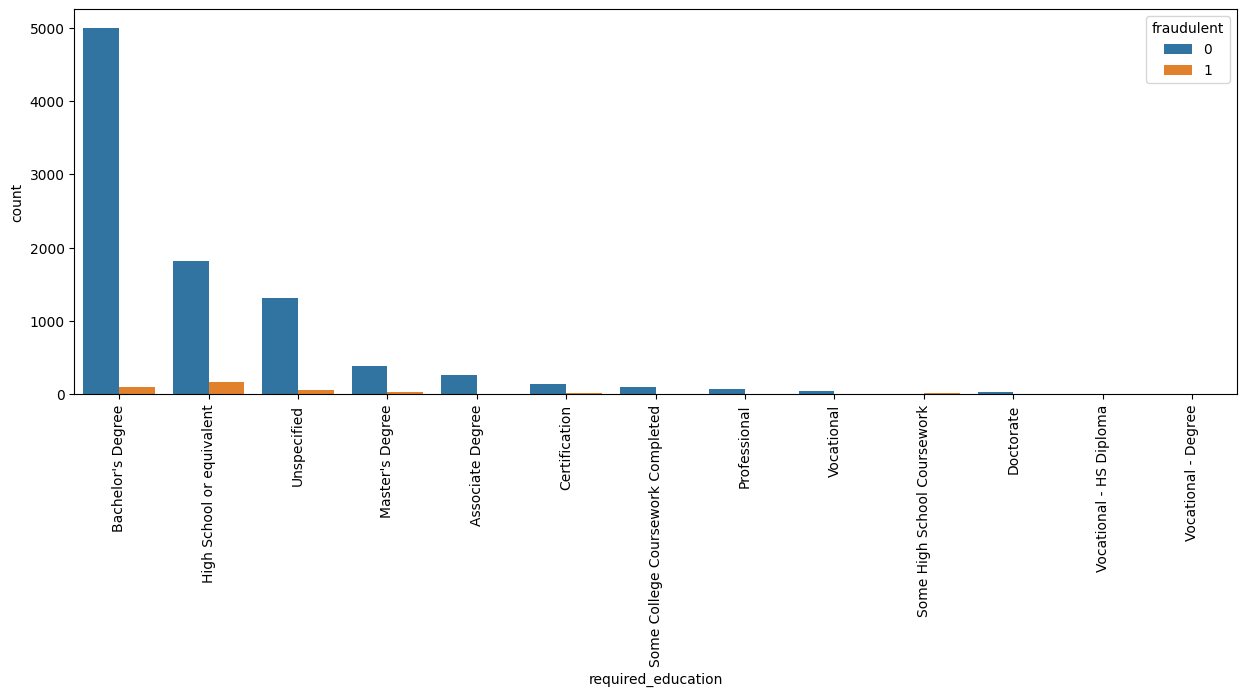

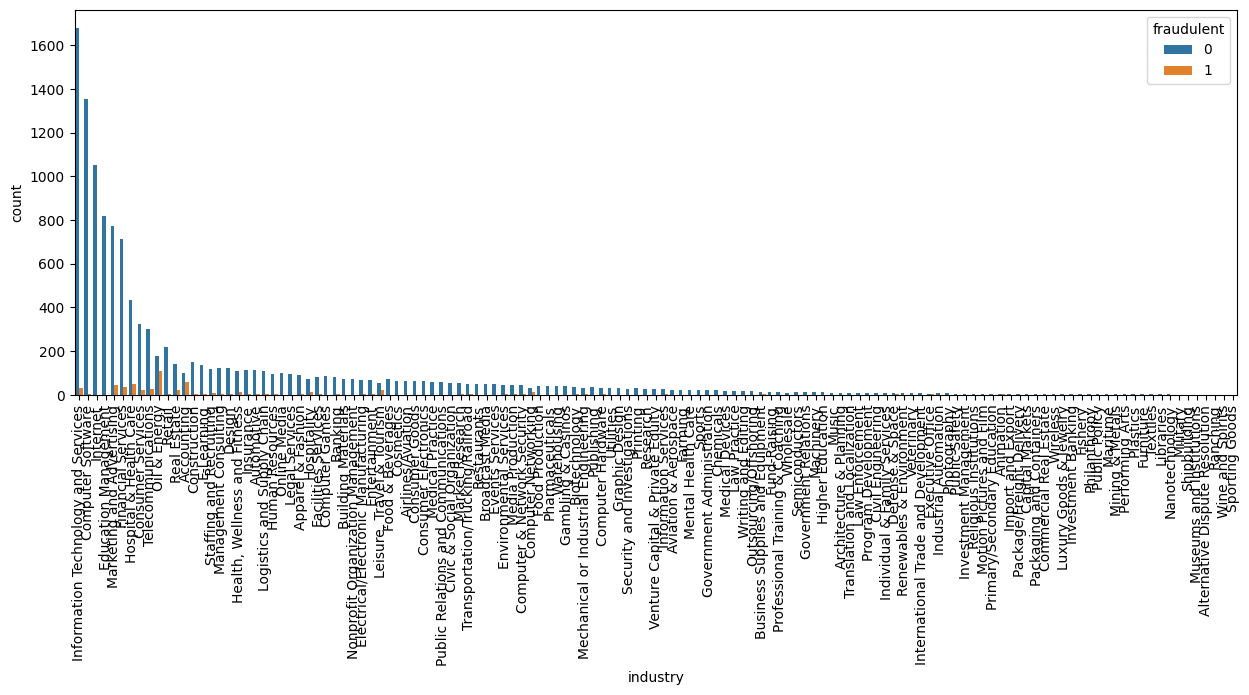

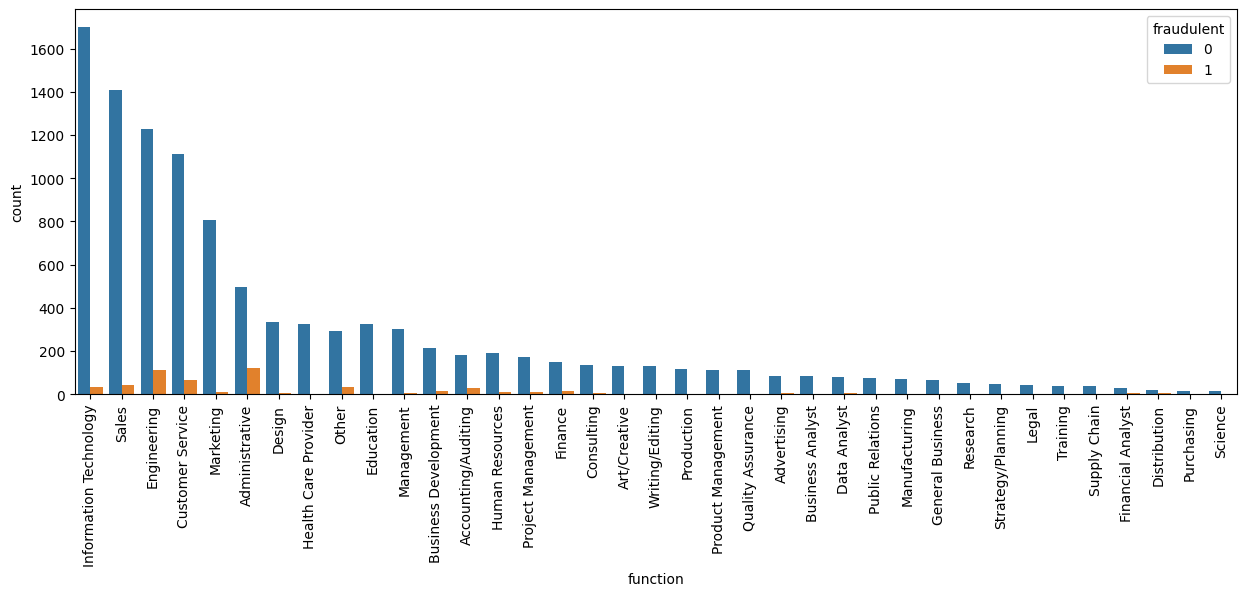